<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Benchmark-pqlite" data-toc-modified-id="Benchmark-pqlite-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Benchmark pqlite</a></span><ul class="toc-item"><li><span><a href="#Time" data-toc-modified-id="Time-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Time</a></span></li><li><span><a href="#Quality" data-toc-modified-id="Quality-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Quality</a></span><ul class="toc-item"><li><span><a href="#Plotting-pq-neighbors-vs-true-neighbors" data-toc-modified-id="Plotting-pq-neighbors-vs-true-neighbors-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Plotting <code>pq neighbors</code> vs <code>true neighbors</code></a></span></li></ul></li><li><span><a href="#precision,-recall,-query_time-vs-n_subvectors-&amp;--n_cells" data-toc-modified-id="precision,-recall,-query_time-vs-n_subvectors-&amp;--n_cells-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span><code>precision, recall, query_time</code> vs <code>n_subvectors</code> &amp;  <code>n_cells</code></a></span></li></ul></li></ul></div>

## Benchmark pqlite

In [176]:
import pqlite
pqlite.__path__
import time

import jina
from jina.math.distance import cdist

import sklearn
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [254]:
import random
import numpy as np
from pqlite import PQLite

#N = 100_000 # number of data points
Nt = 12_500 
Nq = 1
D = 128 # dimentionality / number of features
top_k = 100
n_cells = 18
n_subvectors = 128

# 2,000 128-dim vectors for training
np.random.seed(123)
Xtr, Xte =train_test_split(make_blobs(n_samples = Nt, n_features = D)[0].astype(np.float32), test_size=20)
#Xt = np.random.random((Nt, D)).astype(np.float32)  

# the column schema: (name:str, dtype:type, create_index: bool)
pq = PQLite(d_vector=D, 
            n_cells=n_cells,
            n_subvectors=n_subvectors, 
            columns=[('x', float, True)])
pq.fit(Xtr)
pq.add(Xtr, ids=list(range(len(Xtr))))

2021-11-15 12:05:35.370 | INFO     | pqlite.index:fit:90 - => start training VQ codec with 12480 data...
2021-11-15 12:05:35.819 | INFO     | pqlite.index:fit:93 - => start training PQ codec with 12480 data...
2021-11-15 12:07:06.343 | INFO     | pqlite.index:fit:96 - => pqlite is successfully trained!
2021-11-15 12:07:07.573 | DEBUG    | pqlite.storage.cell:_expand:148 - => total storage capacity is expanded by 0 for 18 cells
2021-11-15 12:07:07.577 | DEBUG    | pqlite.storage.cell:insert:90 - => 12480 new items added


In [255]:
Nq = 1
query = Xte[[10]] 

# without filtering
pq_dists, ids = pq.search(query, k=5)

### Time

In [256]:
%timeit  pq.search(query,  k=top_k)

9.45 ms ± 471 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [257]:
%timeit res = cdist(query, Xtr, metric='euclidean')

2.07 ms ± 85 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Quality

Manually observing slices of a high dimensional space it seems that the
retrieved items from pqlite are nearby the query and the best values from the exact and exhaustive distance computations.

In [258]:
def _precision(predicted, relevant, eval_at):
    """
    fraction of retrieved documents that are relevant to the query
    """
    if eval_at == 0:
        return 0.0
    predicted_at_k = predicted[:eval_at]
    n_predicted_and_relevant = len(set(predicted_at_k).intersection(set(relevant)))

    return n_predicted_and_relevant / len(predicted)

def _recall(predicted, relevant, eval_at):
    """
    fraction of the relevant documents that are successfully retrieved
    """
    if eval_at == 0:
        return 0.0
    predicted_at_k = predicted[:eval_at]
    n_predicted_and_relevant = len(set(predicted_at_k).intersection(set(relevant)))
    return n_predicted_and_relevant/ len(relevant)


In [259]:
query = Xte[[11]]  
true_distances = cdist(query, Xtr, metric='euclidean').flatten()

true_ids = np.argsort(true_distances)[0:top_k]
true_dists = true_distances[true_ids]

In [260]:
true_ids.sort()
true_ids

array([    0,   192,   300,   371,   545,   677,   767,   813,   933,
        1000,  1131,  1219,  1308,  1389,  1590,  1615,  1686,  1713,
        1740,  1802,  1943,  2372,  2447,  2618,  2719,  2921,  3010,
        3258,  3337,  3418,  3926,  3967,  4140,  4376,  4612,  4625,
        4661,  5243,  5433,  5491,  5534,  5619,  5657,  5693,  5699,
        5875,  6016,  6413,  6440,  6511,  6624,  6772,  6825,  7103,
        7125,  7155,  7948,  8025,  8052,  8098,  8251,  8327,  8366,
        8551,  8572,  8931,  9087,  9094,  9239,  9356,  9739,  9867,
        9877,  9952,  9978,  9987, 10077, 10174, 10187, 10214, 10277,
       10457, 10488, 10982, 11059, 11077, 11083, 11115, 11172, 11280,
       11379, 11382, 11445, 11641, 11911, 12001, 12194, 12212, 12234,
       12342])

In [261]:
pq_dists, pq_ids = pq.search(query,  k=top_k)
pq_ids = np.array([int(x) for x in pq_ids[0]])

In [262]:
pq_ids.sort()
pq_ids

array([    0,   192,   371,   545,   608,   677,   767,   933,  1308,
        1590,  1615,  1713,  1802,  1943,  2372,  2447,  2618,  2764,
        2921,  2956,  3337,  3418,  3429,  3715,  3798,  3854,  3926,
        3967,  4028,  4140,  4376,  4612,  4625,  4661,  4698,  4764,
        5243,  5491,  5534,  5619,  5693,  5875,  6016,  6206,  6413,
        6440,  6573,  6624,  6646,  6772,  6825,  6896,  6979,  7103,
        7125,  7155,  7258,  7890,  7947,  7948,  8098,  8251,  8274,
        8327,  8551,  8584,  8931,  9087,  9094,  9239,  9867,  9877,
        9952,  9978,  9980,  9987,  9998, 10077, 10174, 10214, 10277,
       10457, 10563, 10614, 11077, 11083, 11115, 11172, 11280, 11379,
       11382, 11409, 11445, 11641, 11911, 12001, 12194, 12212, 12234,
       12342])

In [264]:
print(_precision(true_ids, pq_ids, top_k))
print(_recall(true_ids, pq_ids, top_k))

0.75
0.75


#### Plotting `pq neighbors` vs `true neighbors`

In [248]:
import matplotlib.pyplot as plt

def paint_slice(Xtr, query, feat1, feat2):
    plt.scatter(Xtr[:,feat1], Xtr[:,feat2], color='blue', alpha=0.2)

    for pq_id in pq_ids:
        plt.scatter(Xtr[pq_id, feat1], Xtr[pq_id, feat2], color='black')

    for true_id in true_ids:
        plt.scatter(Xtr[true_id, feat1], Xtr[true_id, feat2], color='orange')

    plt.scatter(query[:, feat1], query[:, feat2], color='red')
    

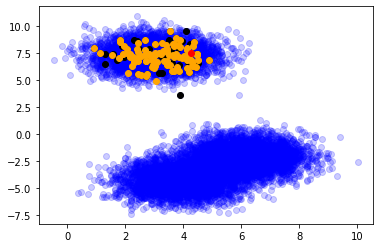

In [249]:
feat1, feat2 = 0, 1
paint_slice(Xtr, query, feat1, feat2)

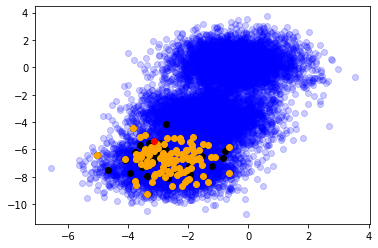

In [250]:
feat1, feat2 = 8, 100
paint_slice(Xtr, query, feat1, feat2)

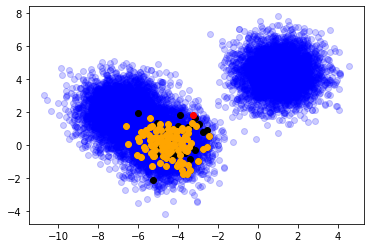

In [251]:
feat1, feat2 = 3,4
paint_slice(Xtr, query, feat1, feat2)


###  `precision, recall, query_time` vs `n_subvectors` &  `n_cells` 

In [1]:
import time
import numpy as np
from pqlite import PQLite

from jina.math.distance import cdist
from jina.math.helper import top_k as _top_k
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

def _precision(predicted, relevant, eval_at):
    """
    fraction of retrieved documents that are relevant to the query
    """
    if eval_at == 0:
        return 0.0
    predicted_at_k = predicted[:eval_at]
    n_predicted_and_relevant = len(set(predicted_at_k).intersection(set(relevant)))

    return n_predicted_and_relevant / len(predicted)

def _recall(predicted, relevant, eval_at):
    """
    fraction of the relevant documents that are successfully retrieved
    """
    if eval_at == 0:
        return 0.0
    predicted_at_k = predicted[:eval_at]
    n_predicted_and_relevant = len(set(predicted_at_k).intersection(set(relevant)))
    return n_predicted_and_relevant/ len(relevant)

def evaluate(predicts, relevants, eval_at):
    recall = 0
    precision = 0
    for _predict, _relevant in zip(predicts, relevants):
        _predict = np.array([int(x) for x in _predict])
        recall += _recall(_predict, _relevant, top_k)
        precision += _precision(_predict, _relevant, top_k)

    return recall / len(predicts), precision / len(predicts)


#N = 100_000 # number of data points
Nt = 125_000
Nq = 1
D = 128 # dimentionality / number of features
top_k = 10
n_cells = 64
n_subvectors = 64
n_queries = 1000

# 2,000 128-dim vectors for training
np.random.seed(123)
Xtr, Xte = train_test_split(make_blobs(n_samples = Nt, n_features = D)[0].astype(np.float32), test_size=20)
print(f'Xtr: {Xtr.shape} vs Xte: {Xte.shape}')

precision_per_query = []
recall_per_query = []
results = []

for n_cells in [8, 16, 32, 64, 128]:
    for n_subvectors in [32, 64, 128]:

        pq = PQLite(d_vector=D,
                    n_cells=n_cells,
                    n_subvectors=n_subvectors)

        t0 = time.time()
        pq.fit(Xtr[:20480])
        train_time = abs(time.time() - t0)

        t0 = time.time()
        pq.add(Xtr, ids=list(range(len(Xtr))))
        index_time = abs(t0 - time.time())

        dists = cdist(Xte, Xtr, metric='euclidean')
        true_dists, true_ids = _top_k(dists, top_k, descending=False)

        t0 = time.time()
        pq_dists, pq_ids = pq.search(Xte, k=top_k)
        query_time = abs(t0 - time.time())

        recall, precision = evaluate(pq_ids, true_ids, top_k)

        results_dict = {'precision': precision,
                        'recall': recall,
                        'train_time': train_time,
                        'index_time': index_time,
                        'query_time': query_time,
                        'indexer_hyperparams': {'n_cells': n_cells,
                                                'n_subvectors': n_subvectors}
                        }
        print(results_dict)

        results.append(results_dict)

2021-11-15 08:34:46.224 | INFO     | pqlite.index:fit:90 - => start training VQ codec with 20480 data...


Xtr: (124980, 128) vs Xte: (20, 128)


2021-11-15 08:34:46.813 | INFO     | pqlite.index:fit:93 - => start training PQ codec with 20480 data...
2021-11-15 08:35:28.611 | INFO     | pqlite.index:fit:96 - => pqlite is successfully trained!
2021-11-15 08:35:33.820 | DEBUG    | pqlite.storage.cell:_expand:148 - => total storage capacity is expanded by 124980 for 8 cells
2021-11-15 08:35:33.827 | DEBUG    | pqlite.storage.cell:insert:90 - => 124980 new items added
2021-11-15 08:35:35.771 | INFO     | pqlite.index:fit:90 - => start training VQ codec with 20480 data...


{'precision': 0.33, 'recall': 0.33, 'train_time': 42.38768696784973, 'index_time': 5.221065044403076, 'query_time': 1.872915267944336, 'indexer_hyperparams': {'n_cells': 8, 'n_subvectors': 32}}


2021-11-15 08:35:36.410 | INFO     | pqlite.index:fit:93 - => start training PQ codec with 20480 data...
2021-11-15 08:37:01.639 | INFO     | pqlite.index:fit:96 - => pqlite is successfully trained!
2021-11-15 08:37:09.290 | DEBUG    | pqlite.storage.cell:_expand:148 - => total storage capacity is expanded by 124980 for 8 cells
2021-11-15 08:37:09.300 | DEBUG    | pqlite.storage.cell:insert:90 - => 124980 new items added
2021-11-15 08:37:11.534 | INFO     | pqlite.index:fit:90 - => start training VQ codec with 20480 data...


{'precision': 0.73, 'recall': 0.73, 'train_time': 85.86931085586548, 'index_time': 7.66510796546936, 'query_time': 2.16772198677063, 'indexer_hyperparams': {'n_cells': 8, 'n_subvectors': 64}}


2021-11-15 08:37:12.140 | INFO     | pqlite.index:fit:93 - => start training PQ codec with 20480 data...
2021-11-15 08:39:39.717 | INFO     | pqlite.index:fit:96 - => pqlite is successfully trained!
2021-11-15 08:39:51.389 | DEBUG    | pqlite.storage.cell:_expand:148 - => total storage capacity is expanded by 124980 for 8 cells
2021-11-15 08:39:51.399 | DEBUG    | pqlite.storage.cell:insert:90 - => 124980 new items added
2021-11-15 08:39:54.419 | INFO     | pqlite.index:fit:90 - => start training VQ codec with 20480 data...


{'precision': 0.93, 'recall': 0.93, 'train_time': 148.18310689926147, 'index_time': 11.686479330062866, 'query_time': 2.9563419818878174, 'indexer_hyperparams': {'n_cells': 8, 'n_subvectors': 128}}


2021-11-15 08:39:55.151 | INFO     | pqlite.index:fit:93 - => start training PQ codec with 20480 data...
2021-11-15 08:40:38.323 | INFO     | pqlite.index:fit:96 - => pqlite is successfully trained!
2021-11-15 08:40:45.023 | DEBUG    | pqlite.storage.cell:_expand:148 - => total storage capacity is expanded by 124980 for 16 cells
2021-11-15 08:40:45.036 | DEBUG    | pqlite.storage.cell:insert:90 - => 124980 new items added
2021-11-15 08:40:46.215 | INFO     | pqlite.index:fit:90 - => start training VQ codec with 20480 data...


{'precision': 0.32999999999999996, 'recall': 0.32999999999999996, 'train_time': 43.904764890670776, 'index_time': 6.719267129898071, 'query_time': 1.09629487991333, 'indexer_hyperparams': {'n_cells': 16, 'n_subvectors': 32}}


2021-11-15 08:40:47.178 | INFO     | pqlite.index:fit:93 - => start training PQ codec with 20480 data...
2021-11-15 08:42:14.522 | INFO     | pqlite.index:fit:96 - => pqlite is successfully trained!
2021-11-15 08:42:22.177 | DEBUG    | pqlite.storage.cell:_expand:148 - => total storage capacity is expanded by 124980 for 16 cells
2021-11-15 08:42:22.188 | DEBUG    | pqlite.storage.cell:insert:90 - => 124980 new items added
2021-11-15 08:42:23.398 | INFO     | pqlite.index:fit:90 - => start training VQ codec with 20480 data...


{'precision': 0.745, 'recall': 0.745, 'train_time': 88.30725908279419, 'index_time': 7.6708550453186035, 'query_time': 1.1464340686798096, 'indexer_hyperparams': {'n_cells': 16, 'n_subvectors': 64}}


2021-11-15 08:42:24.086 | INFO     | pqlite.index:fit:93 - => start training PQ codec with 20480 data...
2021-11-15 08:45:00.207 | INFO     | pqlite.index:fit:96 - => pqlite is successfully trained!
2021-11-15 08:45:11.449 | DEBUG    | pqlite.storage.cell:_expand:148 - => total storage capacity is expanded by 124980 for 16 cells
2021-11-15 08:45:11.462 | DEBUG    | pqlite.storage.cell:insert:90 - => 124980 new items added
2021-11-15 08:45:12.943 | INFO     | pqlite.index:fit:90 - => start training VQ codec with 20480 data...


{'precision': 0.9400000000000002, 'recall': 0.9400000000000002, 'train_time': 156.81013298034668, 'index_time': 11.25960087776184, 'query_time': 1.4163682460784912, 'indexer_hyperparams': {'n_cells': 16, 'n_subvectors': 128}}


2021-11-15 08:45:13.697 | INFO     | pqlite.index:fit:93 - => start training PQ codec with 20480 data...
2021-11-15 08:45:54.875 | INFO     | pqlite.index:fit:96 - => pqlite is successfully trained!
2021-11-15 08:46:00.111 | DEBUG    | pqlite.storage.cell:_expand:148 - => total storage capacity is expanded by 124980 for 32 cells
2021-11-15 08:46:00.124 | DEBUG    | pqlite.storage.cell:insert:90 - => 124980 new items added
2021-11-15 08:46:00.739 | INFO     | pqlite.index:fit:90 - => start training VQ codec with 20480 data...


{'precision': 0.2899999999999999, 'recall': 0.2899999999999999, 'train_time': 41.932196855545044, 'index_time': 5.255139112472534, 'query_time': 0.5477046966552734, 'indexer_hyperparams': {'n_cells': 32, 'n_subvectors': 32}}


2021-11-15 08:46:01.543 | INFO     | pqlite.index:fit:93 - => start training PQ codec with 20480 data...
2021-11-15 08:47:28.276 | INFO     | pqlite.index:fit:96 - => pqlite is successfully trained!
2021-11-15 08:47:36.482 | DEBUG    | pqlite.storage.cell:_expand:148 - => total storage capacity is expanded by 124980 for 32 cells
2021-11-15 08:47:36.496 | DEBUG    | pqlite.storage.cell:insert:90 - => 124980 new items added
2021-11-15 08:47:37.240 | INFO     | pqlite.index:fit:90 - => start training VQ codec with 20480 data...


{'precision': 0.595, 'recall': 0.595, 'train_time': 87.53748512268066, 'index_time': 8.22494888305664, 'query_time': 0.6751902103424072, 'indexer_hyperparams': {'n_cells': 32, 'n_subvectors': 64}}


2021-11-15 08:47:38.090 | INFO     | pqlite.index:fit:93 - => start training PQ codec with 20480 data...
2021-11-15 08:50:07.046 | INFO     | pqlite.index:fit:96 - => pqlite is successfully trained!
2021-11-15 08:50:19.543 | DEBUG    | pqlite.storage.cell:_expand:148 - => total storage capacity is expanded by 124980 for 32 cells
2021-11-15 08:50:19.563 | DEBUG    | pqlite.storage.cell:insert:90 - => 124980 new items added
2021-11-15 08:50:20.555 | INFO     | pqlite.index:fit:90 - => start training VQ codec with 20480 data...


{'precision': 0.6549999999999999, 'recall': 0.6549999999999999, 'train_time': 149.8060851097107, 'index_time': 12.523751974105835, 'query_time': 0.8992969989776611, 'indexer_hyperparams': {'n_cells': 32, 'n_subvectors': 128}}


2021-11-15 08:50:21.687 | INFO     | pqlite.index:fit:93 - => start training PQ codec with 20480 data...
2021-11-15 08:51:08.201 | INFO     | pqlite.index:fit:96 - => pqlite is successfully trained!
2021-11-15 08:51:14.284 | DEBUG    | pqlite.storage.cell:_expand:148 - => total storage capacity is expanded by 124974 for 64 cells
2021-11-15 08:51:14.312 | DEBUG    | pqlite.storage.cell:insert:90 - => 124980 new items added
2021-11-15 08:51:14.764 | INFO     | pqlite.index:fit:90 - => start training VQ codec with 20480 data...


{'precision': 0.215, 'recall': 0.215, 'train_time': 47.64722514152527, 'index_time': 6.1179358959198, 'query_time': 0.36566591262817383, 'indexer_hyperparams': {'n_cells': 64, 'n_subvectors': 32}}


2021-11-15 08:51:15.847 | INFO     | pqlite.index:fit:93 - => start training PQ codec with 20480 data...
2021-11-15 08:52:48.199 | INFO     | pqlite.index:fit:96 - => pqlite is successfully trained!
2021-11-15 08:52:57.407 | DEBUG    | pqlite.storage.cell:_expand:148 - => total storage capacity is expanded by 123965 for 64 cells
2021-11-15 08:52:57.434 | DEBUG    | pqlite.storage.cell:insert:90 - => 124980 new items added
2021-11-15 08:52:57.945 | INFO     | pqlite.index:fit:90 - => start training VQ codec with 20480 data...


{'precision': 0.4, 'recall': 0.4, 'train_time': 93.43564510345459, 'index_time': 9.240575075149536, 'query_time': 0.41728687286376953, 'indexer_hyperparams': {'n_cells': 64, 'n_subvectors': 64}}


2021-11-15 08:52:59.054 | INFO     | pqlite.index:fit:93 - => start training PQ codec with 20480 data...
2021-11-15 08:55:29.469 | INFO     | pqlite.index:fit:96 - => pqlite is successfully trained!
2021-11-15 08:55:41.514 | DEBUG    | pqlite.storage.cell:_expand:148 - => total storage capacity is expanded by 124932 for 64 cells
2021-11-15 08:55:41.539 | DEBUG    | pqlite.storage.cell:insert:90 - => 124980 new items added
2021-11-15 08:55:42.053 | INFO     | pqlite.index:fit:90 - => start training VQ codec with 20480 data...


{'precision': 0.505, 'recall': 0.505, 'train_time': 151.52461910247803, 'index_time': 12.076996088027954, 'query_time': 0.42200589179992676, 'indexer_hyperparams': {'n_cells': 64, 'n_subvectors': 128}}


2021-11-15 08:55:43.467 | INFO     | pqlite.index:fit:93 - => start training PQ codec with 20480 data...
2021-11-15 08:56:26.092 | INFO     | pqlite.index:fit:96 - => pqlite is successfully trained!
2021-11-15 08:56:31.916 | DEBUG    | pqlite.storage.cell:_expand:148 - => total storage capacity is expanded by 81602 for 128 cells
2021-11-15 08:56:31.953 | DEBUG    | pqlite.storage.cell:insert:90 - => 124980 new items added
2021-11-15 08:56:32.217 | INFO     | pqlite.index:fit:90 - => start training VQ codec with 20480 data...


{'precision': 0.22000000000000006, 'recall': 0.22000000000000006, 'train_time': 44.03998112678528, 'index_time': 5.865411758422852, 'query_time': 0.17523694038391113, 'indexer_hyperparams': {'n_cells': 128, 'n_subvectors': 32}}


2021-11-15 08:56:33.602 | INFO     | pqlite.index:fit:93 - => start training PQ codec with 20480 data...
2021-11-15 08:57:59.880 | INFO     | pqlite.index:fit:96 - => pqlite is successfully trained!
2021-11-15 08:58:08.218 | DEBUG    | pqlite.storage.cell:_expand:148 - => total storage capacity is expanded by 72849 for 128 cells
2021-11-15 08:58:08.253 | DEBUG    | pqlite.storage.cell:insert:90 - => 124980 new items added
2021-11-15 08:58:08.546 | INFO     | pqlite.index:fit:90 - => start training VQ codec with 20480 data...


{'precision': 0.385, 'recall': 0.385, 'train_time': 87.66363906860352, 'index_time': 8.378465175628662, 'query_time': 0.2116832733154297, 'indexer_hyperparams': {'n_cells': 128, 'n_subvectors': 64}}


2021-11-15 08:58:09.923 | INFO     | pqlite.index:fit:93 - => start training PQ codec with 20480 data...
2021-11-15 09:00:42.462 | INFO     | pqlite.index:fit:96 - => pqlite is successfully trained!
2021-11-15 09:00:55.228 | DEBUG    | pqlite.storage.cell:_expand:148 - => total storage capacity is expanded by 91974 for 128 cells
2021-11-15 09:00:55.269 | DEBUG    | pqlite.storage.cell:insert:90 - => 124980 new items added


{'precision': 0.32000000000000006, 'recall': 0.32000000000000006, 'train_time': 153.91668391227722, 'index_time': 12.811831712722778, 'query_time': 0.23727893829345703, 'indexer_hyperparams': {'n_cells': 128, 'n_subvectors': 128}}


In [9]:
import pandas as pd
results_df = pd.DataFrame(results)
results_df.sort_values('recall', ascending=False)

,precision,recall,train_time,index_time,query_time,indexer_hyperparams
5,0.940,0.940,156.810133,11.259601,1.416368,"{'n_cells': 16, 'n_subvectors': 128}"
2,0.930,0.930,148.183107,11.686479,2.956342,"{'n_cells': 8, 'n_subvectors': 128}"
4,0.745,0.745,88.307259,7.670855,1.146434,"{'n_cells': 16, 'n_subvectors': 64}"
1,0.730,0.730,85.869311,7.665108,2.167722,"{'n_cells': 8, 'n_subvectors': 64}"
8,0.655,0.655,149.806085,12.523752,0.899297,"{'n_cells': 32, 'n_subvectors': 128}"
7,0.595,0.595,87.537485,8.224949,0.675190,"{'n_cells': 32, 'n_subvectors': 64}"
11,0.505,0.505,151.524619,12.076996,0.422006,"{'n_cells': 64, 'n_subvectors': 128}"
10,0.400,0.400,93.435645,9.240575,0.417287,"{'n_cells': 64, 'n_subvectors': 64}"
13,0.385,0.385,87.663639,8.378465,0.211683,"{'n_cells': 128, 'n_subvectors': 64}"
0,0.330,0.330,42.387687,5.221065,1.872915,"{'n_cells': 8, 'n_subvectors': 32}"
